In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Prep the data

In [64]:
train_raw = pd.read_csv("../input/train.csv", index_col=0)
test_raw = pd.read_csv("../input/test.csv", index_col=0)

In [65]:
y_raw = train_raw.pop('SalePrice')
y_raw_log = np.log(y_raw)

In [66]:
merged_raw = pd.concat([train_raw, test_raw], axis=0)

In [67]:
# convert MSSubClass
merged_raw['MSSubClass'] = merged_raw['MSSubClass'].astype(str)

In [68]:
dummy_merged = pd.get_dummies(merged_raw)

In [69]:
# fix nulls depending on data_description
dummy_merged.LotFrontage.fillna(train_raw.LotFrontage.mean(), inplace=True)
dummy_merged.MasVnrArea.fillna(train_raw.MasVnrArea.mean(), inplace=True)
dummy_merged.BsmtHalfBath.fillna(0, inplace=True)
dummy_merged.BsmtFullBath.fillna(0, inplace=True)
dummy_merged.BsmtFinSF2.fillna(0, inplace=True)
dummy_merged.GarageCars.fillna(0, inplace=True)
dummy_merged.TotalBsmtSF.fillna(0, inplace=True)
dummy_merged.BsmtUnfSF.fillna(0, inplace=True)
dummy_merged.GarageArea.fillna(0, inplace=True)
dummy_merged.BsmtFinSF1.fillna(0, inplace=True)

# replace null in GarageYrBlt to YearBuilt
GarageYrBlt_naIndex = dummy_merged[dummy_merged.GarageYrBlt.isnull()].index
for i in GarageYrBlt_naIndex:
    dummy_merged.GarageYrBlt.set_value(i, dummy_merged.YearBuilt.get_value(i))

In [70]:
dummy_train = dummy_merged.loc[train_raw.index]
dummy_test = dummy_merged.loc[test_raw.index]

In [71]:
def submit(name, pred):
    sub_df = pd.DataFrame(index=test_raw.index)
    sub_df['SalePrice'] = pred
    sub_df.to_csv("../output/" + name + ".csv")

# Lasso with raw data

In [72]:
from sklearn.linear_model import Lasso
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.cross_validation import cross_val_score

In [73]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [74]:
lasso_clf = Lasso(random_state=999)
alphas = np.linspace(5e-4, 6e-4, 10)
param_grid = {'alpha' : alphas}
grid_CV = GridSearchCV(estimator=lasso_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer)

In [75]:
grid_CV.fit(dummy_train, y_raw_log)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=999,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([ 0.0005 ,  0.00051,  0.00052,  0.00053,  0.00054,  0.00056,
        0.00057,  0.00058,  0.00059,  0.0006 ])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

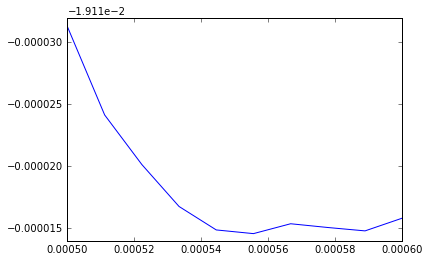

In [76]:
y_pred_log = grid_CV.predict(dummy_test)
plt.gca().invert_yaxis()
pd.Series([score[1] for score in grid_CV.grid_scores_], index=alphas).plot()

In [77]:
print('best score = ', grid_CV.best_score_, ' for alpha = ', grid_CV.best_params_['alpha'])

best score =  -0.0191245786398  for alpha =  0.000555555555556


In [78]:
y_pred = np.exp(y_pred_log)

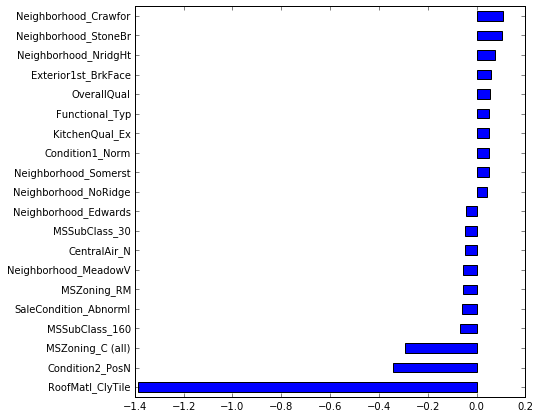

In [79]:
lasso_clf = Lasso(alpha=0.0005, max_iter=5e4).fit(dummy_train, y_raw_log)
coff = pd.Series(lasso_clf.coef_, index=dummy_train.columns).sort_values(ascending=True)
imp_features = pd.concat([coff.head(10), coff.tail(10)])
plt.figure(figsize=[7,7])
imp_features.plot(kind='barh')

In [49]:
# sub.to_csv("../output/sub5_lasso.csv") # score of 0.12164

# Ridge with raw data

In [11]:
from sklearn.linear_model import Ridge

In [25]:
ridge_clf = Ridge(random_state=999)
alphas = np.linspace(11, 12, 100)
param_grid = {'alpha' : alphas}
grid_CV = GridSearchCV(n_jobs=-1, param_grid=param_grid, estimator=ridge_clf, scoring=scorer, cv=5)

In [26]:
grid_CV.fit(dummy_train, y_raw_log)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=999, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([ 11.    ,  11.0101, ...,  11.9899,  12.    ])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

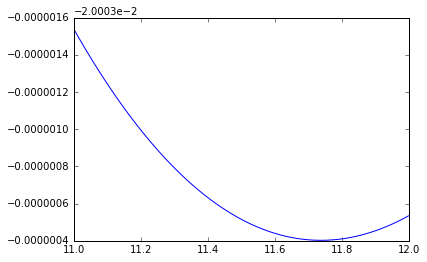

In [38]:
y_pred_log = grid_CV.predict(dummy_test)
plt.gca().invert_yaxis()
pd.Series([score[1] for score in grid_CV.grid_scores_], index=alphas).plot()

In [39]:
print('best score = ', grid_CV.best_score_, ' for alpha = ', grid_CV.best_params_['alpha'])

best score =  -0.0200034026934  for alpha =  11.7373737374


In [40]:
y_pred = np.exp(y_pred_log)
sub = pd.DataFrame(index=test_raw.index)
sub['SalePrice'] = y_pred

In [41]:
sub.to_csv("../output/sub5.csv") # score of 0.12438

In [152]:
ridge_clf = Ridge(random_state=999, normalize=True)
alphas = np.linspace(-5, 5, 10)
param_grid = {'alpha' : alphas}
grid_CV = GridSearchCV(n_jobs=-1, param_grid=param_grid, estimator=ridge_clf, scoring=scorer, cv=5)

In [153]:
grid_CV.fit(dummy_train, y_raw_log)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=999, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([-5.     , -3.88889, -2.77778, -1.66667, -0.55556,  0.55556,
        1.66667,  2.77778,  3.88889,  5.     ])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

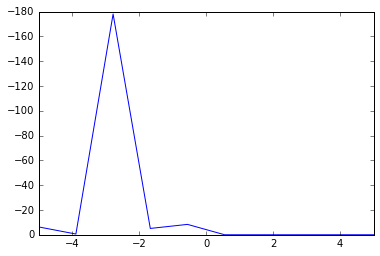

In [154]:
y_pred_log = grid_CV.predict(dummy_test)
plt.gca().invert_yaxis()
pd.Series([score[1] for score in grid_CV.grid_scores_], index=alphas).plot()

In [155]:
print('(with normalization) best score = ', grid_CV.best_score_, ' for alpha = ', grid_CV.best_params_['alpha'])

(with normalization) best score =  -0.0195927360494  for alpha =  0.555555555556


In [156]:
y_pred = np.exp(y_pred_log)
sub = pd.DataFrame(index=test_raw.index)
sub['SalePrice'] = y_pred

In [157]:
sub.to_csv("../output/sub3_ridge_with_normalization.csv") # score of 0.13384

# Elastic net with raw data

In [12]:
from sklearn.linear_model import ElasticNet

In [29]:
elastic_cv = ElasticNet(random_state=999, max_iter=5e4)
grid_params = {'l1_ratio' : np.linspace(1e-10, 1e-5, 10),
              'alpha' : np.linspace(-11, 11, 10)}
grid_CV = GridSearchCV(n_jobs=-1, estimator=elastic_cv, param_grid=grid_params, scoring=scorer, cv=2, verbose=2)

In [ ]:
y_pred_log = grid_CV.predict(dummy_test)
grid_CV.best_params_

In [100]:
from sklearn.linear_model import ElasticNetCV
elastic_cv = ElasticNetCV(n_jobs=-1, cv=5)

In [102]:
elastic_test = dummy_test.copy()
elastic_train = dummy_train.copy()

In [103]:
elastic_cv.fit(elastic_train, y_raw_log)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=-1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [104]:
y_raw_log = elastic_cv.predict(elastic_test)

In [105]:
elastic_cv.alpha_, elastic_cv.l1_ratio_

(2.050481393422634, 0.5)

In [106]:
y_pred = np.exp(y_pred_log)
sub = pd.DataFrame(index=test_raw.index)
sub['SalePrice'] = y_pred

In [107]:
sub.to_csv("../output/sub3_elastic.csv") # score of 0.17329

# combine Ridge and Lasso on raw data

In [14]:
ridge = Ridge(random_state=999, alpha=12.13)
lasso = Lasso(random_state=999, alpha=0.000555555555556, max_iter=5e4)

In [16]:
print(ridge.fit(dummy_train, y_raw_log))
lasso.fit(dummy_train, y_raw_log)

Ridge(alpha=12.13, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=999, solver='auto', tol=0.001)


Lasso(alpha=0.000555555555556, copy_X=True, fit_intercept=True,
   max_iter=50000.0, normalize=False, positive=False, precompute=False,
   random_state=999, selection='cyclic', tol=0.0001, warm_start=False)

In [60]:
y_ridge_log = ridge.predict(dummy_test)
y_lasso_log = lasso.predict(dummy_test)
y_comb = (y_ridge_log + y_lasso_log)/2

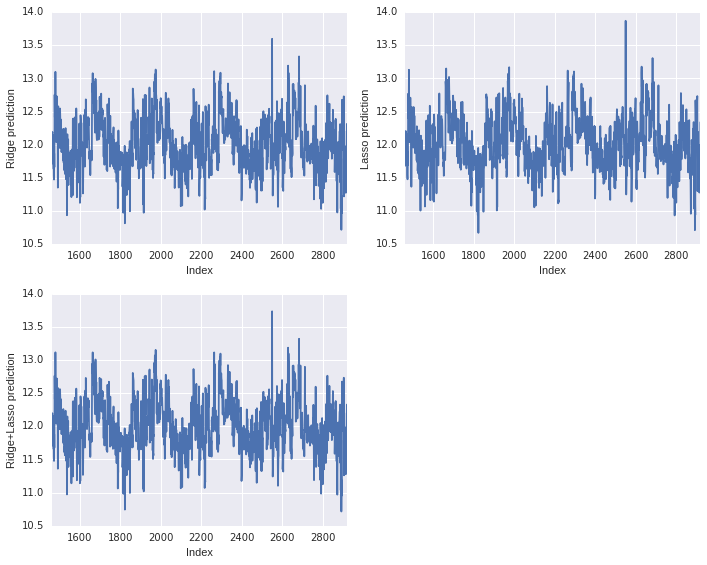

In [61]:
plt.figure(figsize=[10, 8])

plt.subplot(2, 2, 1)
pd.Series(y_ridge_log, index=dummy_test.index).plot()
plt.xlabel("Index")
plt.ylabel("Ridge prediction")

plt.subplot(2, 2, 2)
pd.Series(y_lasso_log, index=dummy_test.index).plot()
plt.xlabel("Index")
plt.ylabel("Lasso prediction")

plt.subplot(2, 2, 3)
pd.Series(y_comb, index=dummy_test.index).plot()
plt.xlabel("Index")
plt.ylabel("Ridge+Lasso prediction")

plt.tight_layout()

In [55]:
y_pred = np.exp(y_comb)
sub = pd.DataFrame(index=test_raw.index)
sub['SalePrice'] = y_pred

In [56]:
sub.to_csv("../output/sub3_R+L.csv") # scored 0.12222